In [1]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from collections import Counter
from sklearn.decomposition import PCA
import pylangacq
import glob
import os

In [2]:
# Replace this with the path to your Brent directory
BASE_PATH = "C:/Users/baroq/OneDrive/Documents/Brent/Brent"
cha_files = glob.glob(os.path.join(BASE_PATH, '**', '*.cha'), recursive=True)
print(f"Found {len(cha_files)} .cha files.")

tokenized_sentences = []

for file in cha_files:
    try:
        with open(file, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                if line.startswith("*MOT:"):
                    # Remove speaker label and lower case
                    line = line[5:].strip().lower()

                    # Remove CHAT annotations: timestamps, brackets, symbols
                    line = re.sub(r"\x15\d+_\d+\x15", "", line)  # remove timestamp markers
                    line = re.sub(r"\[.*?\]", "", line)          # remove bracketed codes
                    line = re.sub(r"[^\w\s]", "", line)          # remove punctuation
                    tokens = line.split()
                    tokens = [w for w in tokens if w.isalpha()]
                    if 3 <= len(tokens) <= 10:
                        tokenized_sentences.append(tokens)
    except Exception as e:
        print(f"Skipping {file} due to error:\n{e}")

print(f"\n✅ Loaded {len(tokenized_sentences)} clean utterances from {len(cha_files)} files.")
print ("example: " + str(tokenized_sentences[0]))

Found 211 .cha files.

✅ Loaded 93643 clean utterances from 211 files.
example: ['sammy', 'see', 'the', 'kitty', 'margie', 'sammy', 'wants', 'out']


In [3]:
# --- Step 1: Build vocabulary ---
vocab_size = 100
all_tokens = [word for sent in tokenized_sentences for word in sent]
vocab = [word for word, _ in Counter(all_tokens).most_common(vocab_size)]
word_to_idx = {word: i for i, word in enumerate(vocab)}
num_words = len(vocab)

# --- Step 2: Filter sentences to known vocab only ---
filtered_sentences = [
    [word for word in sent if word in word_to_idx]
    for sent in tokenized_sentences
]
filtered_sentences = [sent for sent in filtered_sentences if len(sent) >= 2]

# --- Step 3: Function to convert sentence to rate-coded firing input ---
def sentence_to_rates(sentence, base_rate=5, high_rate=50):
    rates = np.full(num_words, base_rate)
    for word in sentence:
        if word in word_to_idx:
            rates[word_to_idx[word]] = high_rate
    return rates * Hz

# --- Step 4: Define and run the spiking network ---
start_scope()
duration = 100 * ms
N_input = num_words
N_output = 10

PG = PoissonGroup(N_input, rates=np.zeros(N_input) * Hz)

eqs = '''
dv/dt = (I - v) / (10*ms) : 1
I : 1
'''
G = NeuronGroup(N_output, eqs, threshold='v>1', reset='v=0', method='linear')
G.I = '0.5*i/N_output'

S = Synapses(PG, G,
             '''
             w : 1
             dApre/dt = -Apre / (20*ms) : 1 (event-driven)
             dApost/dt = -Apost / (20*ms) : 1 (event-driven)
             ''',
             on_pre='''
             v_post += w
             Apre += 0.01
             w = clip(w + Apost, 0, 1)
             ''',
             on_post='''
             Apost += 0.01
             w = clip(w + Apre, 0, 1)
             ''')
S.connect()
S.w = '0.2*rand()'

output_vectors = []
used_sentences = []
for sent in filtered_sentences[:500]:
    used_sentences.append(sent)
    input_rates = sentence_to_rates(sent)
    PG.rates = input_rates

    # Create new spike monitors each run
    spikemon_in = SpikeMonitor(PG)
    spikemon_out = SpikeMonitor(G)

    run(duration)

    # Count spikes for this sentence
    spikes = np.bincount(spikemon_out.i, minlength=N_output)
    output_vectors.append(spikes)

output_vectors = np.array(output_vectors)

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


In [8]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import plotly.express as px

# Recombine words for display
sentence_text = [' '.join(s) for s in used_sentences]

# Project with PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(output_vectors)
X_pca = PCA(n_components=2).fit_transform(X_scaled)

df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Sentence': sentence_text
})

fig = px.scatter(
    df, x='PC1', y='PC2', hover_name='Sentence',
    title='Emergent Sentence Clusters from Output Spikes',
    opacity=0.7
)
fig.show()

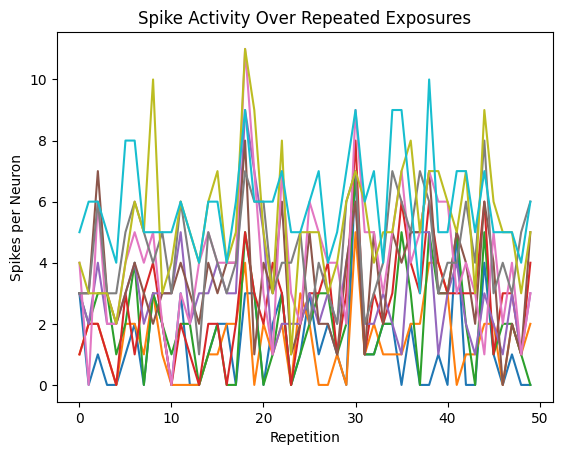

In [9]:
# Experiment 1: Category Emergence with Repeated Exposure
# Fixed version
from brian2 import *

repeated_sentence = ['do', 'you', 'want', 'it']
n_repeats = 50
spike_patterns = []

for _ in range(n_repeats):
    start_scope()

    # Rebuild network
    PG = PoissonGroup(N_input, rates=sentence_to_rates(repeated_sentence))

    eqs = '''
    dv/dt = (I - v) / (10*ms) : 1
    I : 1
    '''
    G = NeuronGroup(N_output, eqs, threshold='v>1', reset='v=0', method='linear')
    G.I = '0.5*i/N_output'

    S = Synapses(PG, G,
                 '''
                 w : 1
                 dApre/dt = -Apre / (20*ms) : 1 (event-driven)
                 dApost/dt = -Apost / (20*ms) : 1 (event-driven)
                 ''',
                 on_pre='''
                 v_post += w
                 Apre += 0.01
                 w = clip(w + Apost, 0, 1)
                 ''',
                 on_post='''
                 Apost += 0.01
                 w = clip(w + Apre, 0, 1)
                 ''')
    S.connect()
    S.w = '0.2*rand()'

    # Spike monitor
    spikemon = SpikeMonitor(G)

    run(duration)

    # Record spikes
    spike_counts = np.bincount(spikemon.i, minlength=N_output)
    spike_patterns.append(spike_counts)

# Plot results
import matplotlib.pyplot as plt
spike_patterns = np.array(spike_patterns)
plt.plot(spike_patterns)
plt.title("Spike Activity Over Repeated Exposures")
plt.xlabel("Repetition")
plt.ylabel("Spikes per Neuron")
plt.show()

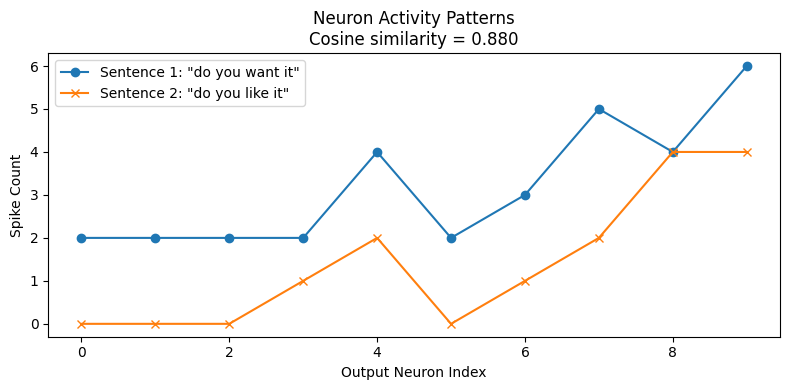

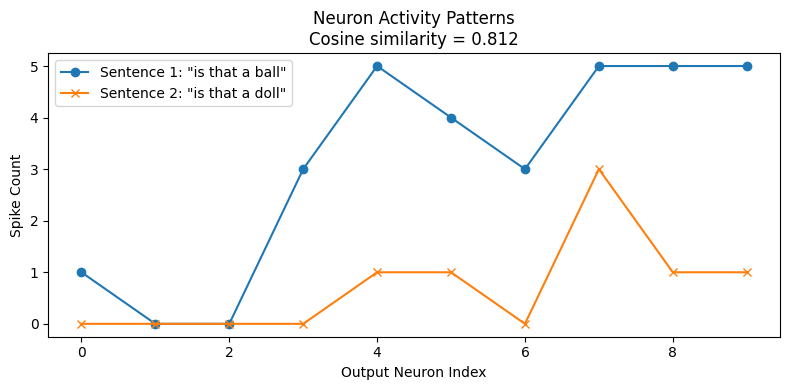

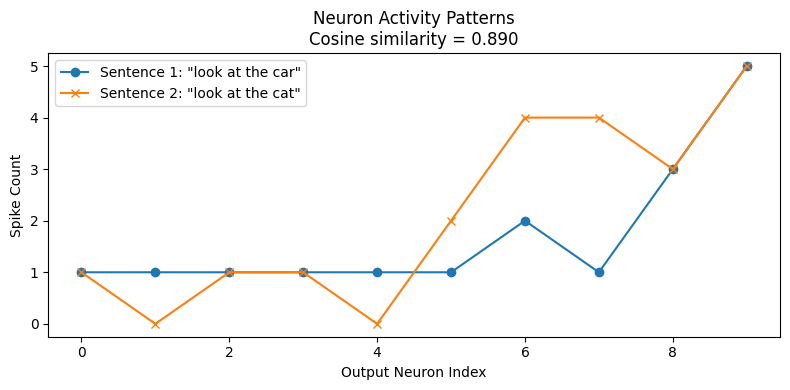

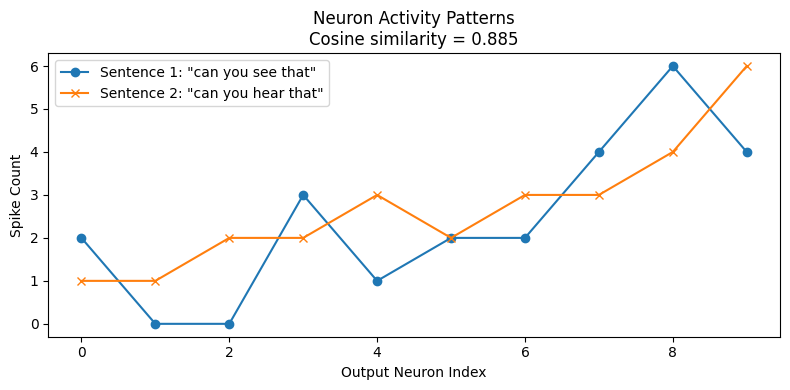

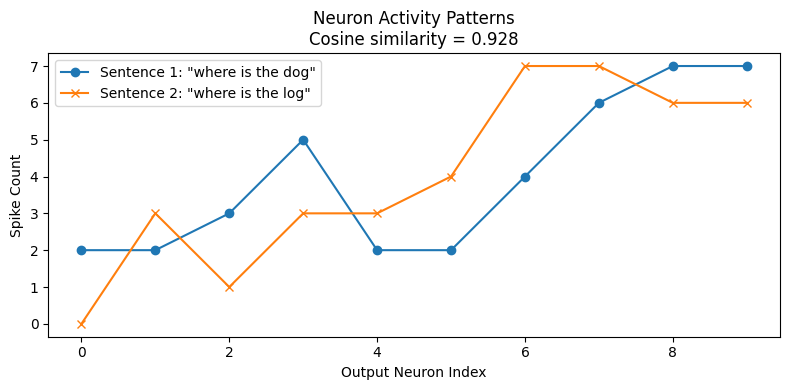

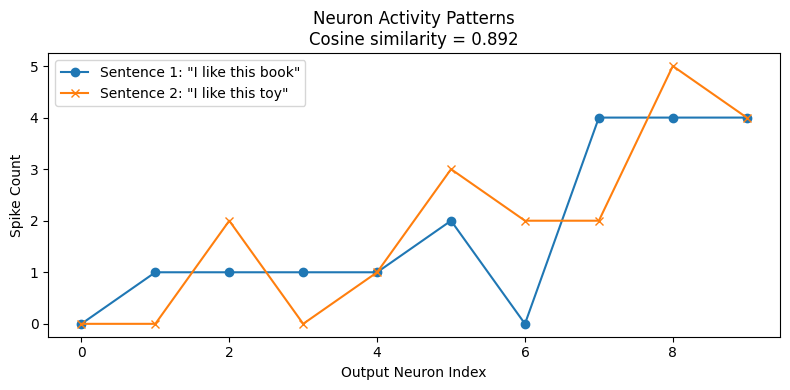

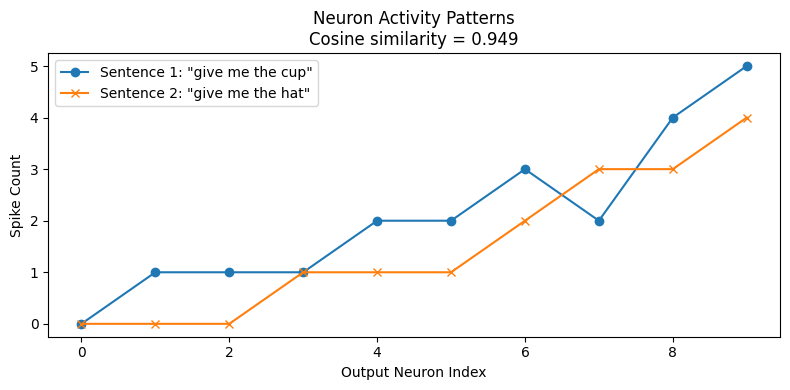

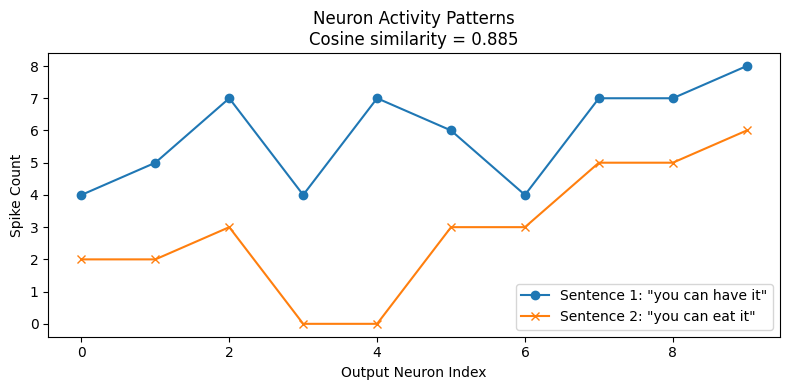

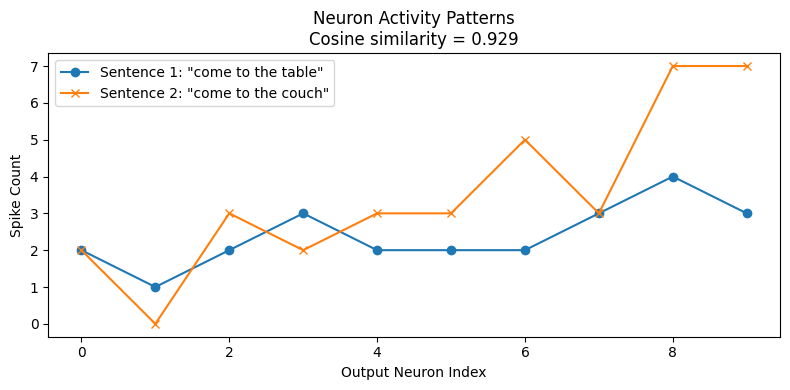

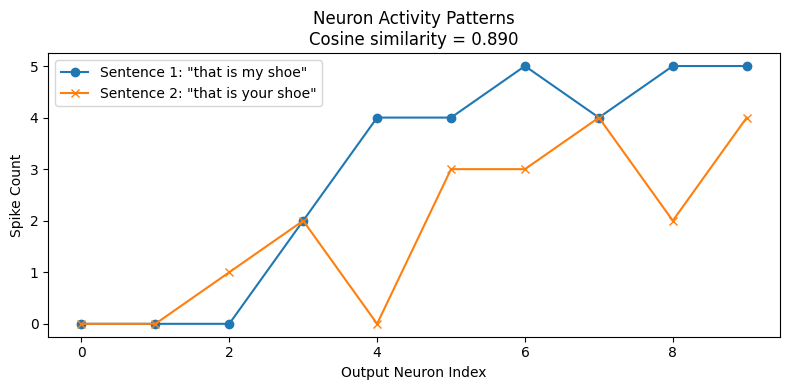

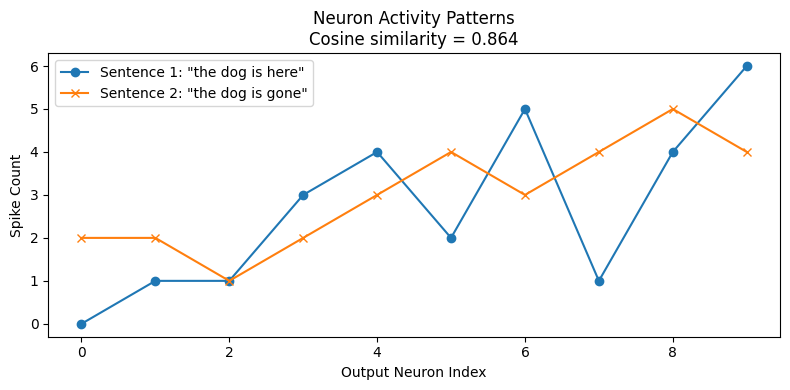

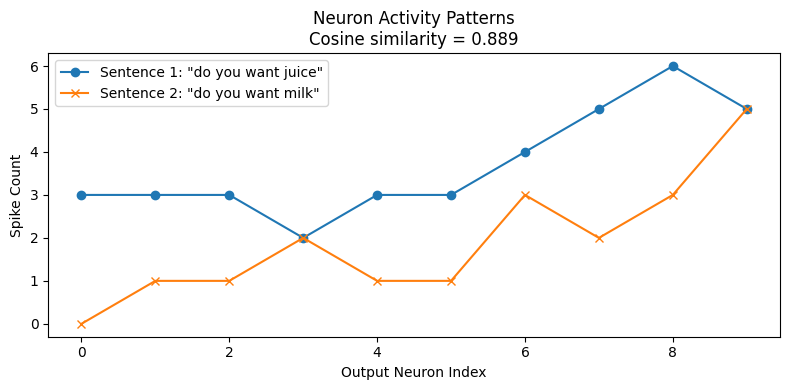

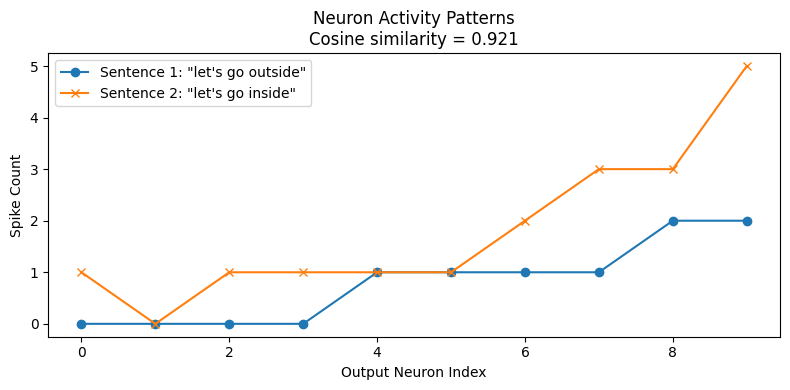

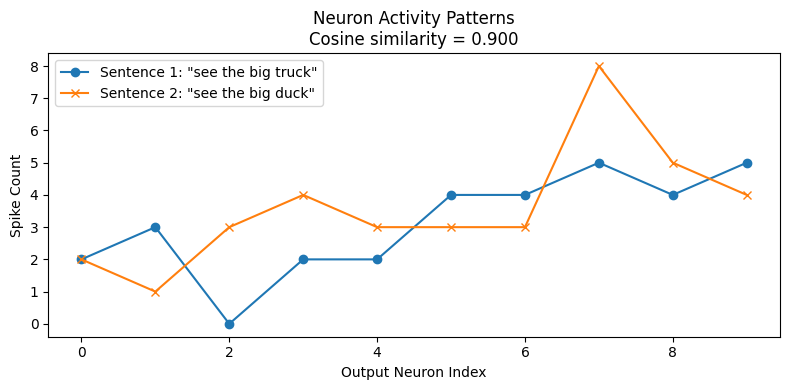

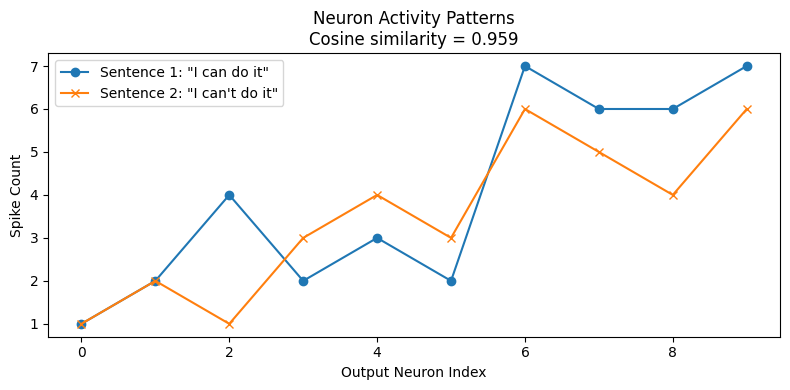

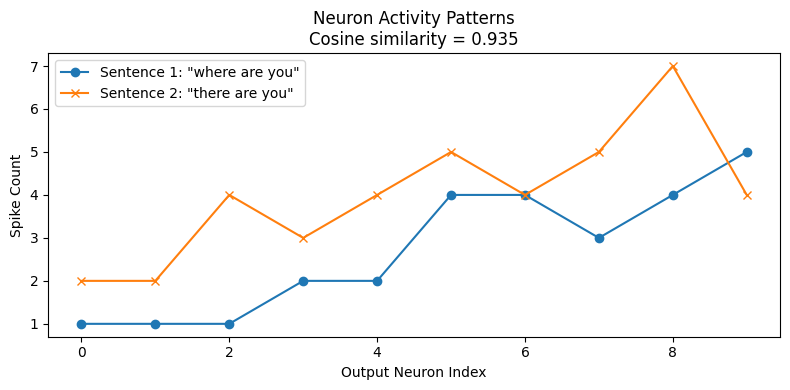

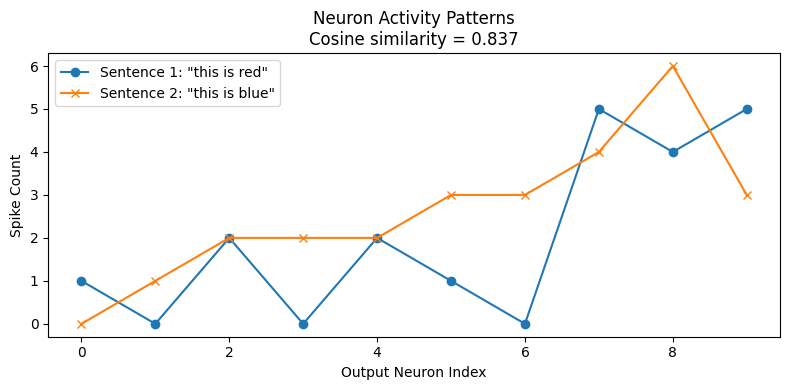

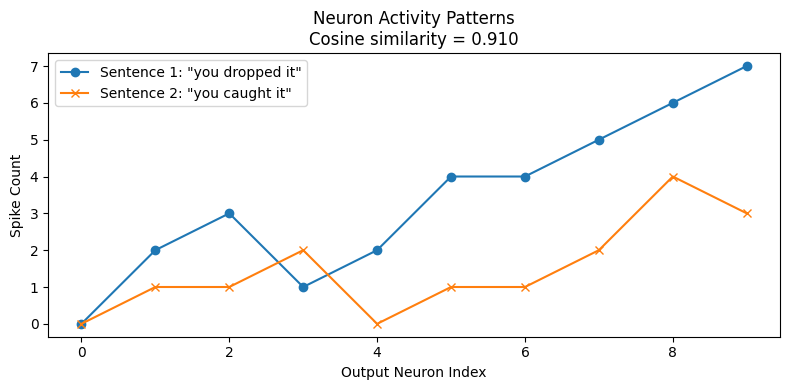

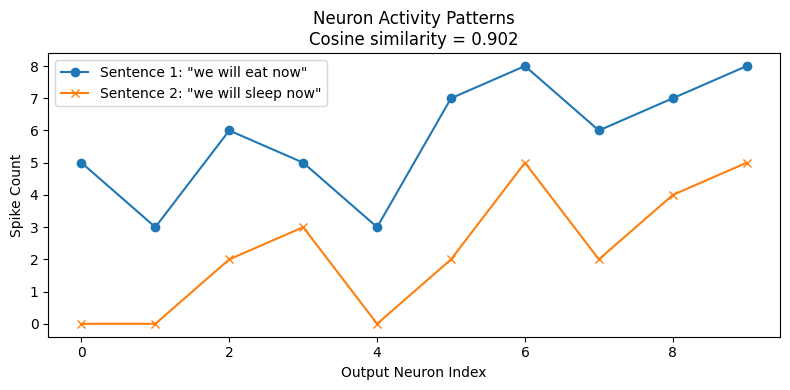

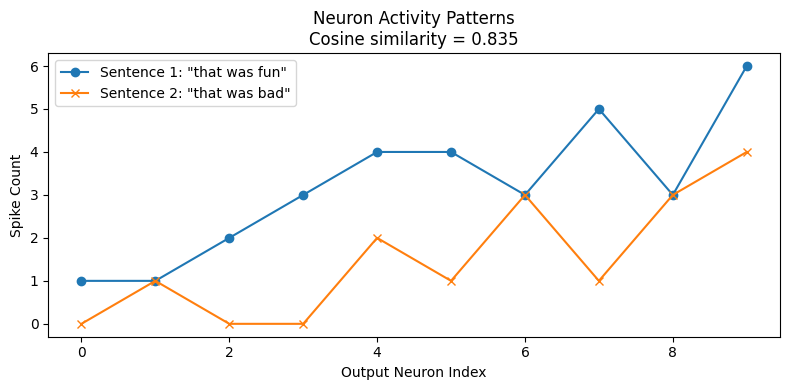

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from sklearn.metrics.pairwise import cosine_similarity

# Define 20 minimal contrast sentence pairs
sentence_pairs = [
    (["do", "you", "want", "it"], ["do", "you", "like", "it"]),
    (["is", "that", "a", "ball"], ["is", "that", "a", "doll"]),
    (["look", "at", "the", "car"], ["look", "at", "the", "cat"]),
    (["can", "you", "see", "that"], ["can", "you", "hear", "that"]),
    (["where", "is", "the", "dog"], ["where", "is", "the", "log"]),
    (["I", "like", "this", "book"], ["I", "like", "this", "toy"]),
    (["give", "me", "the", "cup"], ["give", "me", "the", "hat"]),
    (["you", "can", "have", "it"], ["you", "can", "eat", "it"]),
    (["come", "to", "the", "table"], ["come", "to", "the", "couch"]),
    (["that", "is", "my", "shoe"], ["that", "is", "your", "shoe"]),
    (["the", "dog", "is", "here"], ["the", "dog", "is", "gone"]),
    (["do", "you", "want", "juice"], ["do", "you", "want", "milk"]),
    (["let's", "go", "outside"], ["let's", "go", "inside"]),
    (["see", "the", "big", "truck"], ["see", "the", "big", "duck"]),
    (["I", "can", "do", "it"], ["I", "can't", "do", "it"]),
    (["where", "are", "you"], ["there", "are", "you"]),
    (["this", "is", "red"], ["this", "is", "blue"]),
    (["you", "dropped", "it"], ["you", "caught", "it"]),
    (["we", "will", "eat", "now"], ["we", "will", "sleep", "now"]),
    (["that", "was", "fun"], ["that", "was", "bad"]),
]

# Plot each contrast pair
for idx, (s1, s2) in enumerate(sentence_pairs):

    # Clear state and rerun simulation
    start_scope()

    # Input
    PG = PoissonGroup(num_words, rates=sentence_to_rates(s1))
    G = NeuronGroup(N_output, eqs, threshold='v>1', reset='v=0', method='linear')
    G.I = '0.5*i/N_output'
    S = Synapses(PG, G,
        '''
        w : 1
        dApre/dt = -Apre / (20*ms) : 1 (event-driven)
        dApost/dt = -Apost / (20*ms) : 1 (event-driven)
        ''',
        on_pre='''
        v_post += w
        Apre += 0.01
        w = clip(w + Apost, 0, 1)
        ''',
        on_post='''
        Apost += 0.01
        w = clip(w + Apre, 0, 1)
        '''
    )
    S.connect()
    S.w = '0.2*rand()'

    spikemon1 = SpikeMonitor(G)
    run(100*ms)
    spikes1 = np.bincount(spikemon1.i, minlength=N_output)

    # Second sentence
    start_scope()
    PG = PoissonGroup(num_words, rates=sentence_to_rates(s2))
    G = NeuronGroup(N_output, eqs, threshold='v>1', reset='v=0', method='linear')
    G.I = '0.5*i/N_output'
    S = Synapses(PG, G,
        '''
        w : 1
        dApre/dt = -Apre / (20*ms) : 1 (event-driven)
        dApost/dt = -Apost / (20*ms) : 1 (event-driven)
        ''',
        on_pre='''
        v_post += w
        Apre += 0.01
        w = clip(w + Apost, 0, 1)
        ''',
        on_post='''
        Apost += 0.01
        w = clip(w + Apre, 0, 1)
        '''
    )
    S.connect()
    S.w = '0.2*rand()'

    spikemon2 = SpikeMonitor(G)
    run(100*ms)
    spikes2 = np.bincount(spikemon2.i, minlength=N_output)

    # Compute similarity
    sim = cosine_similarity([spikes1], [spikes2])[0][0]

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(spikes1, 'o-', label=f"Sentence 1: \"{' '.join(s1)}\"")
    plt.plot(spikes2, 'x-', label=f"Sentence 2: \"{' '.join(s2)}\"")
    plt.title(f"Neuron Activity Patterns\nCosine similarity = {sim:.3f}")
    plt.xlabel("Output Neuron Index")
    plt.ylabel("Spike Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


Similarity to training sentence 1 (look at that): 0.774
Similarity to training sentence 2 (look at this): 0.878
Test sentence: look at those


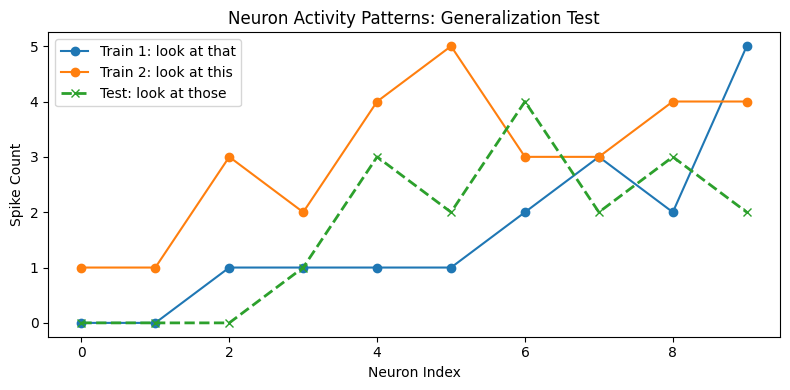

In [11]:
# Experiment 3: Generalization
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Sentences
training_sentences = [
    ['look', 'at', 'that'],
    ['look', 'at', 'this']
]
test_sentence = ['look', 'at', 'those']

def simulate_sentence(sentence):
    """Run simulation for a single sentence and return spike counts."""
    start_scope()

    PG = PoissonGroup(num_words, rates=sentence_to_rates(sentence))
    G = NeuronGroup(N_output, eqs, threshold='v>1', reset='v=0', method='linear')
    G.I = '0.5*i/N_output'

    S = Synapses(PG, G,
        '''
        w : 1
        dApre/dt = -Apre / (20*ms) : 1 (event-driven)
        dApost/dt = -Apost / (20*ms) : 1 (event-driven)
        ''',
        on_pre='''
        v_post += w
        Apre += 0.01
        w = clip(w + Apost, 0, 1)
        ''',
        on_post='''
        Apost += 0.01
        w = clip(w + Apre, 0, 1)
        '''
    )
    S.connect()
    S.w = '0.2*rand()'

    spikemon = SpikeMonitor(G)
    run(duration)

    return np.bincount(spikemon.i, minlength=N_output)

# Run simulations
train_vectors = [simulate_sentence(sent) for sent in training_sentences]
test_vector = simulate_sentence(test_sentence)

# Compute cosine similarities
similarities = cosine_similarity([test_vector], train_vectors)[0]

# Display results
for i, sim in enumerate(similarities):
    print(f"Similarity to training sentence {i+1} ({' '.join(training_sentences[i])}): {sim:.3f}")
print(f"Test sentence: {' '.join(test_sentence)}")

# Plot for intuition
plt.figure(figsize=(8, 4))
for i, vec in enumerate(train_vectors):
    plt.plot(vec, 'o-', label=f"Train {i+1}: {' '.join(training_sentences[i])}")
plt.plot(test_vector, 'x--', label=f"Test: {' '.join(test_sentence)}", linewidth=2)
plt.title("Neuron Activity Patterns: Generalization Test")
plt.xlabel("Neuron Index")
plt.ylabel("Spike Count")
plt.legend()
plt.tight_layout()
plt.show()